<a href="https://colab.research.google.com/github/lucastbeloni/Sistema-de-Informacoes-sobre-Mortalidade/blob/main/SIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import  pandas as pd
import warnings
warnings.filterwarnings('ignore')
import missingno as msn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import basedosdados as bd

In [3]:
df = pd.read_csv('municipio_causa_idade_sexo_raca.csv')

In [4]:
df.head()

,ano,sigla_uf,id_municipio,causa_basica,idade,sexo,raca_cor,numero_obitos
0,1996,AC,1200000,R99,NaN,1.0,NaN,1.0
1,1996,AC,1200000,V892,25.0,1.0,NaN,1.0
2,1996,AC,1200000,X959,NaN,1.0,3.0,1.0
3,1996,AC,1200000,X959,NaN,1.0,NaN,1.0
4,1996,AC,1200013,A419,71.0,2.0,NaN,1.0


In [5]:
df = df[df.duplicated('causa_basica', keep=False)] # seleciona nomes que aparecem mais de uma vez

total_by_state = df.groupby('sigla_uf').numero_obitos.sum() # agrupa o total por estado
df = df.merge(total_by_state, on='sigla_uf', suffixes=('', '_total_by_state')) # une os dados com total por estado

df['freq_per_100k'] = 100_000 * df.numero_obitos / df.numero_obitos_total_by_state # cria o total por estado por 100k pessoas

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9895481 entries, 0 to 9895480
Data columns (total 10 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   ano                           int64  
 1   sigla_uf                      object 
 2   id_municipio                  int64  
 3   causa_basica                  object 
 4   idade                         float64
 5   sexo                          float64
 6   raca_cor                      float64
 7   numero_obitos                 float64
 8   numero_obitos_total_by_state  float64
 9   freq_per_100k                 float64
dtypes: float64(6), int64(2), object(2)
memory usage: 830.5+ MB


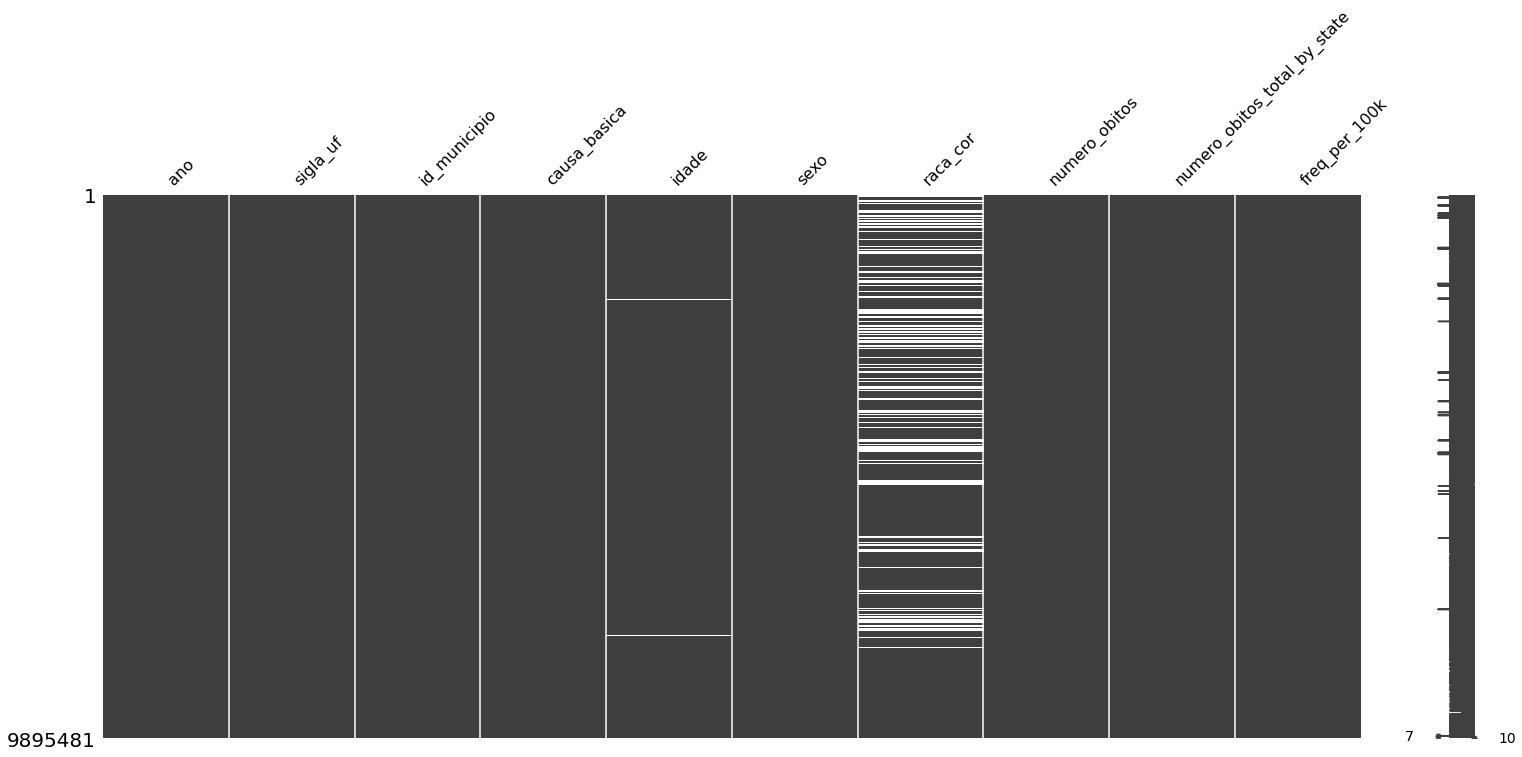

In [7]:
msn.matrix(df)
plt.show()

In [8]:
df.isnull().sum()


ano                                   0
sigla_uf                              0
id_municipio                          0
causa_basica                          0
idade                             60955
sexo                               1443
raca_cor                        2369809
numero_obitos                         0
numero_obitos_total_by_state          0
freq_per_100k                         0
dtype: int64

In [9]:
#msn.bar(df)

#plt.show()

In [10]:
df.isnull().sum()/df.shape[0]

ano                             0.000000
sigla_uf                        0.000000
id_municipio                    0.000000
causa_basica                    0.000000
idade                           0.006160
sexo                            0.000146
raca_cor                        0.239484
numero_obitos                   0.000000
numero_obitos_total_by_state    0.000000
freq_per_100k                   0.000000
dtype: float64

In [11]:
df['sigla_uf'].value_counts()


SP    2207885
MG    1136565
RJ    1012698
RS     752171
BA     644684
PR     622185
PE     534942
CE     373885
SC     330943
GO     280872
PA     238842
MA     207881
ES     200523
PB     199111
AL     156444
RN     149624
MS     131648
MT     131557
PI     129539
SE     103052
AM      94526
DF      82480
RO      64802
TO      48449
AC      26925
AP      18754
RR      14494
Name: sigla_uf, dtype: int64

In [12]:
df[['numero_obitos', 'sigla_uf']].groupby('sigla_uf').sum().sort_values('numero_obitos', ascending=False)

,numero_obitos
sigla_uf,
SP,2846460.0
RJ,1385343.0
MG,1226135.0
RS,835886.0
BA,733651.0
PR,684686.0
PE,621659.0
CE,438751.0
SC,348302.0


In [13]:
state2abbr = {
    'AC': 'BR.AC', 'AL': 'BR.AL', 'AP': 'BR.AP',
    'AM': 'BR.AM', 'BA': 'BR.BA', 'CE': 'BR.CE',
    'DF': 'BR.DF', 'ES': 'BR.ES',
    'GO': 'BR.GO', 'MA': 'BR.MA', 'MT': 'BR.MT',
    'MS': 'BR.MS', 'MG': 'BR.MG',
    'PA': 'BR.PA', 'PB': 'BR.PB', 'PR': 'BR.PR',
    'PE': 'BR.PE', 'PI': 'BR.PI', 'RJ': 'BR.RJ',
    'RN': 'BR.RN', 'RS': 'BR.RS',
    'RO': 'BR.RO', 'RR': 'BR.RR', 'SC': 'BR.SC',
    'SP': 'BR.SP', 'SE': 'BR.SE', 'TO': 'BR.TO',
}

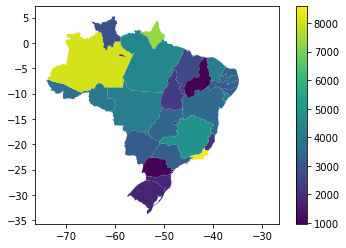

In [14]:
def visualize_text(df, text):
    text_df = df.query(f'causa_basica == "{text}"') # filtra o nome escolhido
    text_df = text_df.groupby('sigla_uf', as_index=False).sum() # agrupa pelos estados
    text_df.sigla_uf = text_df.sigla_uf.apply(lambda x: state2abbr[x]) # abrevia os estados
    text_df = text_df.rename(columns={'sigla_uf': 'HASC_1'}) # renomeia a coluna

    fig, ax = plt.subplots(1, 1)
    br_map = gpd.read_file('gadm36_BRA_1.shp') # lê o mapa
    br_map = br_map.merge(text_df, on='HASC_1', how='outer') # une o mapa com os dados
    br_map.plot(column='freq_per_100k', ax=ax, legend=True) # desenha o gráfico

visualize_text(df, 'R99')

In [15]:
df.head()

,ano,sigla_uf,id_municipio,causa_basica,idade,sexo,raca_cor,numero_obitos,numero_obitos_total_by_state,freq_per_100k
0,1996,AC,1200000,R99,NaN,1.0,NaN,1.0,30159.0,3.31576
1,1996,AC,1200000,V892,25.0,1.0,NaN,1.0,30159.0,3.31576
2,1996,AC,1200000,X959,NaN,1.0,3.0,1.0,30159.0,3.31576
3,1996,AC,1200000,X959,NaN,1.0,NaN,1.0,30159.0,3.31576
4,1996,AC,1200013,A419,71.0,2.0,NaN,1.0,30159.0,3.31576


In [19]:
df.groupby('causa_basica').numero_obitos.sum().sort_values(ascending=False).head(10)

causa_basica
R98     818175.0
I219    734806.0
I64     536182.0
R99     450439.0
J449    273823.0
E149    231031.0
J189    207005.0
C349    185659.0
I500    181585.0
X959    173941.0
Name: numero_obitos, dtype: float64

In [21]:
df.groupby(['sigla_uf', 'causa_basica']).numero_obitos.sum().sort_values(ascending=False).head(10)

sigla_uf  causa_basica
SP        I219            210998.0
BA        R98             140885.0
RJ        R99             118945.0
          I219            101696.0
SP        I64              99387.0
          R99              91494.0
          J180             87987.0
PE        R98              86871.0
RJ        I64              74756.0
MG        R98              71968.0
Name: numero_obitos, dtype: float64

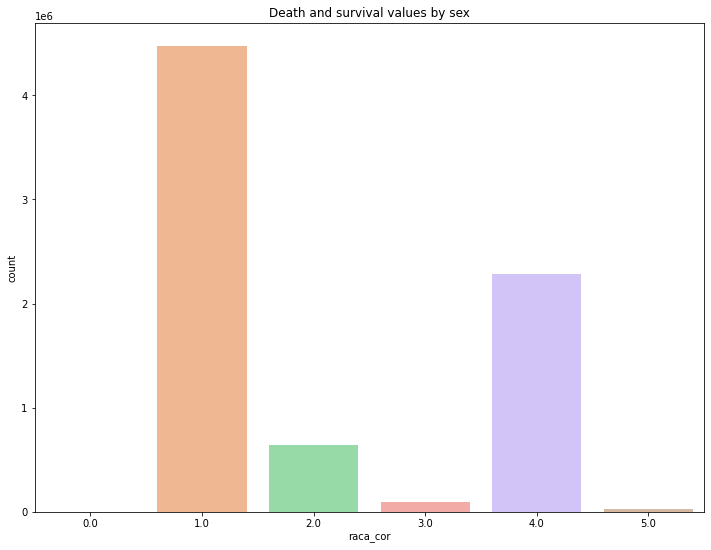

In [22]:
plt.figure(figsize=(12,9))
sns.set_palette('pastel')
sns.countplot(x='raca_cor',data=df)
plt.title('Death and survival values by sex')
plt.show()

In [34]:
teste = df.groupby(['raca_cor']).sum()['numero_obitos'].reset_index()

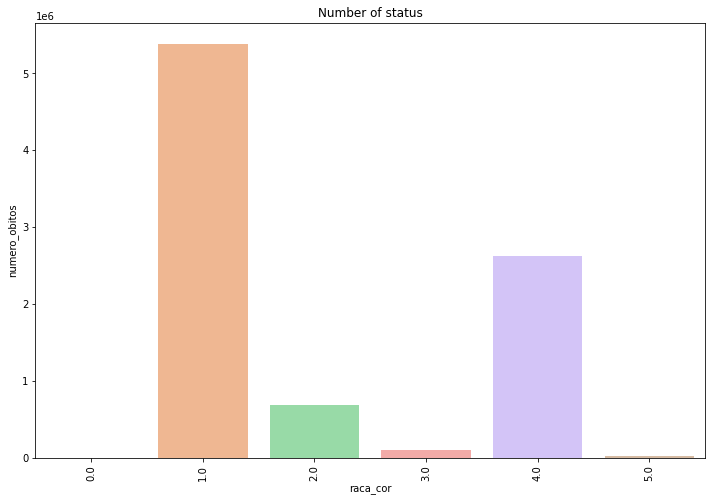

In [35]:
plt.figure(figsize=(12, 8))
sns.barplot(x=teste.raca_cor, y=teste.numero_obitos)
plt.title('Number of status')
plt.xlabel('raca_cor')
plt.ylabel('numero_obitos')
plt.xticks(rotation=90)
plt.show()